<a href="https://colab.research.google.com/github/Running-Machine-ML23-2/problem_2/blob/main/Binary_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

Thanks for 서현, 데이터를 불러올 수 있도록 여러 개로 균등/랜덤하게 나눈 것을 불러옵니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
import numpy as np
from collections import Counter

# Load the subsetted pickle file  9500개임
subset_pickle_path = '/content/drive/MyDrive/dataset_/mon_data_sub1.pkl'
with open(subset_pickle_path, 'rb') as f:
    X1, X2, y = pickle.load(f)

# Convert tuples to lists
X1_mon = list(X1) # Array for timestamps
X2_mon = list(X2) # Array for packetsize
y = list(y) # label

outgoing_packets_fraction = []  # Array to store the outgoing packets fraction for unmonitored data
std_outgoing_packet_ordering = []  # Array to store the standard deviation of outgoing packet ordering for unmonitored data

for i in range(len(X1_mon)):
    outgoing_packets = 0
    packet_ordering = []
    for j in range(len(X1_mon[i])):
        if X2_mon[i][j] > 0:
            outgoing_packets += 1
            packet_ordering.append(X1_mon[i][j])
    outgoing_packets_fraction.append(outgoing_packets / len(X1_mon[i]))
    std_outgoing_packet_ordering.append(np.std(packet_ordering))


In [4]:
import pickle
import numpy as np

TOTAL_URLS = 3000  # total number in the dataset

print("Loading datafile...")
with open('./drive/MyDrive/dataset_/unmon_data_sub1.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

X1_unmon = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_unmon = [] # Array to store instances (direction*size) - size information
outgoing_packets_fraction_un = []  # Array to store the outgoing packets fraction for unmonitored data
std_outgoing_packet_ordering_un = []  # Array to store the standard deviation of outgoing packet ordering for unmonitored data

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    outgoing_packets = 0
    packet_ordering = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512)  # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
        if dr == 1:
            outgoing_packets += 1
            packet_ordering.append(abs(c))
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    outgoing_packets_fraction_un.append(outgoing_packets / len(x[i]))
    std_outgoing_packet_ordering_un.append(np.std(packet_ordering))


Loading datafile...


In [5]:
#Categorical features-3
def cat3_feat(X2):
  in_packet_of_total_packet=[]
  for i in range(len(X2)):
    num_in_pack=0
    for j in range(len(X2[i])):
      if X2[i][j] == -512:
        num_in_pack+=1
    in_packet_of_total_packet.append(num_in_pack/len(X2[i]))
  return in_packet_of_total_packet

# 5.number of outgoing packets
def cat5_feat(X2_mon):
  out_sum=[0]*len(X2_mon)
  for i in range(len(X2_mon)):
    sum=0
    for j in X2_mon[i]:
      if j > 0:
        sum+=1
    out_sum[i]=sum
  return out_sum

cat5_result=cat5_feat(X2_mon)

MAX_SEQUENCE_LENGTH = 100  # 시퀀스의 최대 길이

def pad_sequence(seq, max_length):
    if len(seq) < max_length:
        seq += [0] * (max_length - len(seq))  # 패딩
    else:
        seq = seq[:max_length]  # 잘라냄
    return seq

def compute_bursts(sequence):
    bursts = []
    current_burst = sequence[0]

    for size in sequence[1:]:
        if np.sign(size) == np.sign(current_burst):
            current_burst += size
        else:
            bursts.append(current_burst)
            current_burst = size
    bursts.append(current_burst)
    return bursts

X2_all = X2_mon + X2_unmon

X1_all= X1_mon + X1_unmon

X2_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X2_all]
X1_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X1_all]

X_mon_bursts = [pad_sequence(compute_bursts(x), MAX_SEQUENCE_LENGTH) for x in X2_mon]
X_unmon_bursts = [pad_sequence(compute_bursts(x), MAX_SEQUENCE_LENGTH) for x in X2_unmon]
X_bursts_all = X_mon_bursts+X_unmon_bursts

X_mon_cumsum = [pad_sequence(np.cumsum(x).tolist(), MAX_SEQUENCE_LENGTH) for x in X2_mon]
X_unmon_cumsum = [pad_sequence(np.cumsum(x).tolist(), MAX_SEQUENCE_LENGTH) for x in X2_unmon]
X_cumsum_all = X_mon_cumsum + X_unmon_cumsum

num_packets = [sum(1 for size in instance_sizes if size < 0) for instance_sizes in X2_mon]
num_packets_un = [sum(1 for size in instance_sizes if size < 0) for instance_sizes in X2_unmon]
X_CAT1 = num_packets+num_packets_un
X_CAT2 = outgoing_packets_fraction+outgoing_packets_fraction_un
X_CAT3 = cat3_feat(X2_mon)+cat3_feat(X2_unmon)
X_CAT4 = std_outgoing_packet_ordering + std_outgoing_packet_ordering_un
X_CAT5 = cat5_feat(X2_mon)+cat5_feat(X2_unmon)

X_CAT1 = np.array(X_CAT1).reshape(-1, 1)
X_CAT2 = np.array(X_CAT2).reshape(-1, 1)
X_CAT3 = np.array(X_CAT3).reshape(-1, 1)
X_CAT4 = np.array(X_CAT4).reshape(-1, 1)
X_CAT5 = np.array(X_CAT5).reshape(-1, 1)

In [ ]:
y = y + [-1] * 3000

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# 피처 목록
features = [X2_all, X1_all, X_bursts_all, X_cumsum_all, X_CAT1, X_CAT2, X_CAT4,X_CAT3,X_CAT5]
feature_names = ['X2_all', 'X1_all', 'X_bursts_all', 'X_cumsum_all', 'X_CAT1', 'X_CAT2', 'X_CAT4','X_CAT3','X_CAT5']

# 결과를 저장할 딕셔너리
results = {}
high_acc_models = {}  # 정확도가 0.99 이상인 모델을 저장할 딕셔너리

# 레이블 재할당
y = [1]*len(X1_mon) + [-1]*len(X1_unmon)

# 가능한 모든 조합에 대해
for r in range(1, len(features) + 1):
    for subset_indices in combinations(range(len(features)), r):
        subset = [features[i] for i in subset_indices]
        subset_names = [feature_names[i] for i in subset_indices]

        # 피처를 합칩니다
        X = np.concatenate([np.array(feature) for feature in subset], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 모델 초기화
        clf = AdaBoostClassifier(n_estimators=100,random_state=42)

        # 모델 학습
        clf.fit(X_train, y_train)

        # 예측
        y_pred = clf.predict(X_test)

        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)

        # 결과 저장
        results[tuple(subset_names)] = accuracy

        # 정확도가 0.99 이상인 경우에만 모델 저장
        if accuracy >= 0.98:
            high_acc_models[tuple(subset_names)] = clf

# 결과 출력
for subset, accuracy in results.items():
    print("Features: ", subset)
    print("Accuracy: {:.3f}".format(accuracy))


Features:  ('X2_all',)
Accuracy: 0.999
Features:  ('X1_all',)
Accuracy: 0.964
Features:  ('X_bursts_all',)
Accuracy: 1.000
Features:  ('X_cumsum_all',)
Accuracy: 0.999
Features:  ('X_CAT1',)
Accuracy: 0.765
Features:  ('X_CAT2',)
Accuracy: 0.769
Features:  ('X_CAT4',)
Accuracy: 0.769
Features:  ('X_CAT3',)
Accuracy: 0.770
Features:  ('X_CAT5',)
Accuracy: 0.769
Features:  ('X2_all', 'X1_all')
Accuracy: 0.999
Features:  ('X2_all', 'X_bursts_all')
Accuracy: 1.000
Features:  ('X2_all', 'X_cumsum_all')
Accuracy: 1.000
Features:  ('X2_all', 'X_CAT1')
Accuracy: 1.000
Features:  ('X2_all', 'X_CAT2')
Accuracy: 1.000
Features:  ('X2_all', 'X_CAT4')
Accuracy: 0.999
Features:  ('X2_all', 'X_CAT3')
Accuracy: 1.000
Features:  ('X2_all', 'X_CAT5')
Accuracy: 0.999
Features:  ('X1_all', 'X_bursts_all')
Accuracy: 1.000
Features:  ('X1_all', 'X_cumsum_all')
Accuracy: 0.999
Features:  ('X1_all', 'X_CAT1')
Accuracy: 0.964
Features:  ('X1_all', 'X_CAT2')
Accuracy: 0.965
Features:  ('X1_all', 'X_CAT4')
Accur

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 결과 및 Confusion matrix 출력
print("Confusion Matrix: ")
print(cm)

Features:  ('X2_all', 'X1_all', 'X_bursts_all', 'X_cumsum_all', 'X_CAT1', 'X_CAT2', 'X_CAT4', 'X_CAT3', 'X_CAT5')
Accuracy: 1.000
Confusion Matrix: 
[[ 579    0]
 [   1 1920]]


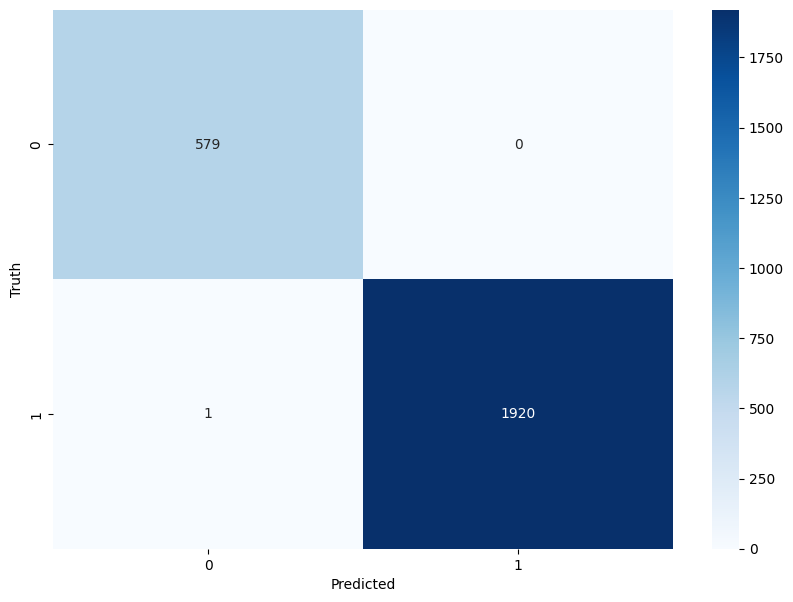

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix 생성
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix 시각화
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Binary Classification Cross Validation

cross_val_score 함수를 사용

5-fold cross-validation을 수행, cv=5 옵션으로 설정

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 피처 목록
features = [X2_all, X1_all, X_bursts_all, X_cumsum_all, X_CAT1, X_CAT2, X_CAT4,X_CAT3,X_CAT5]
feature_names = ['X2_all', 'X1_all', 'X_bursts_all', 'X_cumsum_all', 'X_CAT1', 'X_CAT2', 'X_CAT4','X_CAT3','X_CAT5']

# 결과를 저장할 딕셔너리
results = {}
best_model = None
best_accuracy = 0
best_features = None

# 가능한 모든 조합에 대해
for r in range(1, len(features) + 1):
    for subset_indices in combinations(range(len(features)), r):
        subset = [features[i] for i in subset_indices]
        subset_names = [feature_names[i] for i in subset_indices]

        # 피처를 합칩니다
        X = np.concatenate([np.array(feature) for feature in subset], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 모델 초기화
        clf = AdaBoostClassifier(n_estimators=100,random_state=42)

        # 모델 학습
        clf.fit(X_train, y_train)

        # 예측
        y_pred = clf.predict(X_test)

        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)

        # 교차 검증
        scores = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation
        print("Feature Combination: ", subset_names)  # 피처 조합 출력
        print("Cross-validation scores: ", scores)

        # 결과 저장
        results[tuple(subset_names)] = accuracy

        # 가장 높은 정확도를 갖는 모델 저장
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = clf
            best_features = subset_names

# 가장 높은 정확도를 갖는 피처 조합의 피처 중요도 계산
importances = best_model.feature_importances_
print("Best Features: ", best_features)
print("Best Accuracy: {:.3f}".format(best_accuracy))
print("Importances: ", importances)
indices = np.argsort(importances)
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [best_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# 결과 출력
for subset, accuracy in results.items():
    print("Features: ", subset)
    print("Accuracy: {:.3f}".format(accuracy))


Feature Combination:  ['X2_all']
Cross-validation scores:  [0.9996 0.9996 0.9992 0.9996 0.9996]
Feature Combination:  ['X1_all']
Cross-validation scores:  [0.9588 0.9616 0.962  0.9604 0.952 ]
Feature Combination:  ['X_bursts_all']
Cross-validation scores:  [1.     0.9996 0.9992 1.     1.    ]
Feature Combination:  ['X_cumsum_all']
Cross-validation scores:  [1.     0.9992 0.9988 0.9996 0.9996]
Feature Combination:  ['X_CAT1']
Cross-validation scores:  [0.7632 0.7604 0.76   0.7628 0.7584]
Feature Combination:  ['X_CAT2']
Cross-validation scores:  [0.7612 0.7596 0.7596 0.7608 0.7592]
Feature Combination:  ['X_CAT4']
Cross-validation scores:  [0.758  0.7592 0.76   0.76   0.7608]
Feature Combination:  ['X_CAT3']
Cross-validation scores:  [0.7648 0.762  0.7604 0.766  0.7568]
Feature Combination:  ['X_CAT5']
Cross-validation scores:  [0.76   0.7596 0.7604 0.7596 0.7604]
Feature Combination:  ['X2_all', 'X1_all']
Cross-validation scores:  [1.     0.9996 0.9988 1.     1.    ]
Feature Combinatio

# ROC

In [7]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_bin = label_binarize(y, classes=[-1, 1])
n_classes = y_bin.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

clf = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0))
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

# 각 클래스에 대해 ROC AUC를 계산합니다.
roc_auc = []
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc.append(auc(fpr, tpr))

# Precision과 Recall을 계산합니다.
y_test_multiclass = y_test.argmax(axis=1)
y_pred_multiclass = y_score.argmax(axis=1)

precision = precision_score(y_test_multiclass, y_pred_multiclass, average='macro')
recall = recall_score(y_test_multiclass, y_pred_multiclass, average='macro')

print("ROC AUC: ", roc_auc)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))


ROC AUC:  [0.0]
Precision: 0.500
Recall: 0.116


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


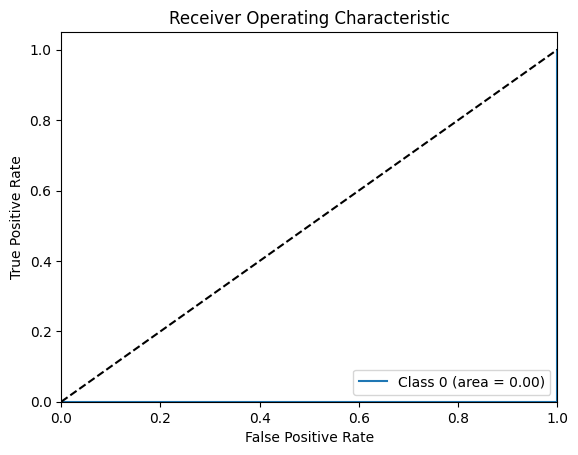

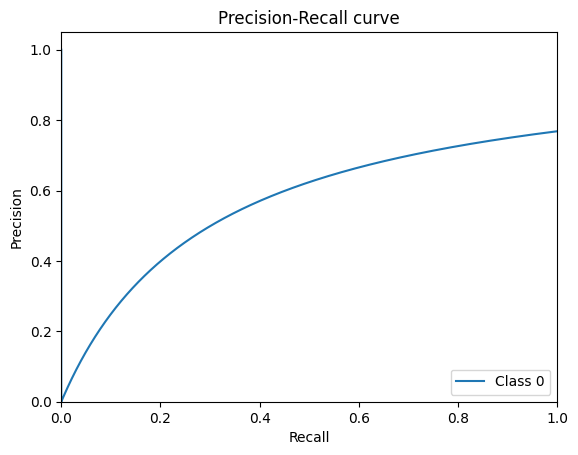

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC curve를 그립니다.
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (area = {:.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve를 그립니다.
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    plt.plot(recall, precision, label='Class {}'.format(i))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()


# Feature importance 정리

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# 피처 목록
features = [X2_all, X1_all, X_bursts_all, X_cumsum_all, X_CAT1, X_CAT2, X_CAT4,X_CAT3,X_CAT5]
feature_names = ['X2_all', 'X1_all', 'X_bursts_all', 'X_cumsum_all', 'X_CAT1', 'X_CAT2', 'X_CAT4','X_CAT3','X_CAT5']

# 결과를 저장할 딕셔너리
results = {}
high_acc_models = {}  # 정확도가 0.99 이상인 모델을 저장할 딕셔너리

# 레이블 재할당
y = [1]*len(X1_mon) + [-1]*len(X1_unmon)

# 가능한 모든 조합에 대해
for r in range(1, len(features) + 1):
    for subset_indices in combinations(range(len(features)), r):
        subset = [features[i] for i in subset_indices]
        subset_names = [feature_names[i] for i in subset_indices]

        # 피처를 합칩니다
        X = np.concatenate([np.array(feature) for feature in subset], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 모델 초기화
        clf = AdaBoostClassifier(n_estimators=100,random_state=42)

        # 모델 학습
        clf.fit(X_train, y_train)

        # 예측
        y_pred = clf.predict(X_test)

        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)

        # 결과 저장
        results[tuple(subset_names)] = accuracy

        # 정확도가 0.99 이상인 경우에만 모델 저장
        if accuracy >= 0.98:
            high_acc_models[tuple(subset_names)] = clf

# 결과 출력
for subset, accuracy in results.items():
    print("Features: ", subset)
    print("Accuracy: {:.3f}".format(accuracy))


# 정확도가 0.99 이상인 모델의 피처 중요도 출력
for subset, model in high_acc_models.items():
    importances = model.feature_importances_
    print("Features: ", subset)
    print("Importances: ", importances)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 0.03 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.
 0.01 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.06
 0.   0.   0.   0.   0.02 0.   0.   0.02 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Features:  ('X2_all', 'X1_all', 'X_bursts_all', 'X_cumsum_all', 'X_CAT2')
Importances:  [0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.02 0.   0.   0.02 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.

In [ ]:
import numpy as np

# 각 메인 피처를 넘파이 배열로 변환합니다
features = [np.array(feature) for feature in features]

# 각 메인 피처의 크기를 계산합니다
feature_sizes = [feature.shape[1] for feature in features]

# 각 메인 피처의 시작 인덱스를 계산합니다
feature_start_indices = np.cumsum([0] + feature_sizes[:-1])

# 각 메인 피처의 중요도를 계산합니다
feature_importances = [np.sum(importances[start_index:start_index+size])
                       for start_index, size in zip(feature_start_indices, feature_sizes)]

# 각 메인 피처의 중요도를 출력합니다
for feature_name, importance in zip(feature_names, feature_importances):
    print("Feature: ", feature_name)
    print("Importance: ", importance)


Feature:  X2_all
Importance:  0.13999999999999999
Feature:  X1_all
Importance:  0.13
Feature:  X_bursts_all
Importance:  0.62
Feature:  X_cumsum_all
Importance:  0.07
Feature:  X_CAT1
Importance:  0.0
Feature:  X_CAT2
Importance:  0.0
Feature:  X_CAT4
Importance:  0.02
Feature:  X_CAT3
Importance:  0.0
Feature:  X_CAT5
Importance:  0.02


In [ ]:
# 중요도의 합을 계산합니다
importance_sum = np.sum(feature_importances)

print("Sum of importances: ", importance_sum)

Sum of importances:  1.0


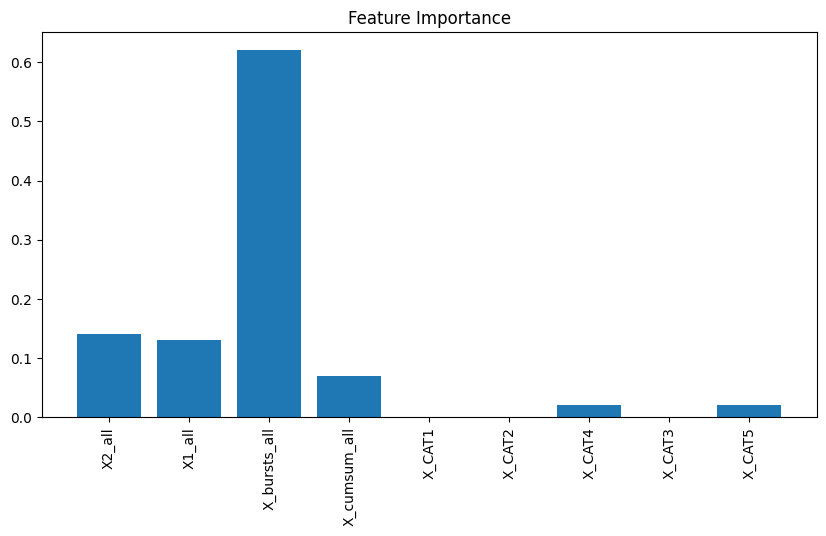

In [ ]:
import matplotlib.pyplot as plt

# 피처 중요도를 바 플롯으로 그립니다
plt.figure(figsize=(10,5))
plt.title("Feature Importance")
plt.bar(feature_names, feature_importances)
plt.xticks(rotation='vertical')
plt.show()
